In [18]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from tensorflow.python.client import device_lib
tf.debugging.set_log_device_placement(True)

Instructions for updating:
non-resource variables are not supported in the long term


In [19]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device_lib.list_local_devices()

Num GPUs Available:  1


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 2387023134674092609
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 2252026676
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6736772096845829147
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:06:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [20]:
# Create some tensors
a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])
c = tf.matmul(a, b)

print(c)

Tensor("MatMul:0", shape=(2, 2), dtype=float32)


In [21]:
# Place tensors on the CPU
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

# Run on the GPU
c = tf.matmul(a, b)
print(c)

Tensor("MatMul_1:0", shape=(2, 2), dtype=float32)


In [22]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

In [23]:
N = 1500
D = 2
M = 3 #no of hidden nodes
K = 3 #no of classes

In [24]:
def convert_2_indicator(Yin) :
    N = len(Yin)
    K = np.max(Yin) + 1
    Yout = np.zeros((N, K))
    for n in range(N) :
        Yout[n, Yin[n]] = 1
    return Yout

def get_accuracy(Y, T) :
    Y_labels = np.argmax(Y, axis = 1)
    T_labels = np.argmax(T, axis = 1)
    return (Y_labels == T_labels).sum() / Y_labels.shape[0]

def my_softmax(A) :
    N = A.shape[0]
    M = A.shape[1]
    Out = np.zeros((N, M))
    for i in range(N) :
        for j in range(M) :
            Out[i][j] = np.exp(A[i][j]) / np.exp(A[i]).sum()
    return Out

def softmax(A) :
    expA = np.exp(A)
    return expA / expA.sum(axis = 1, keepdims=True)


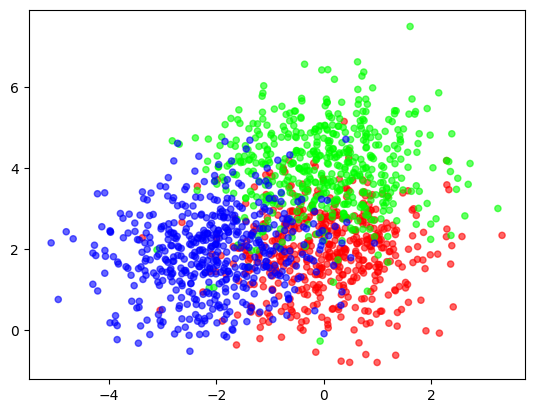

In [34]:
X = np.random.randn(N, D)
#3 random gaussian clouds
X[:500] += np.array([0, -2]) 
X[:1000] += np.array([2, 2]) 
X[:1501] += np.array([-2, 2]) 

Y = np.array([0] * (N // 3) + [1] * (N // 3) + [2] * (N // 3))
T = convert_2_indicator(Y)

plt.scatter(X[:, 0], X[:, 1], s = 20, c = T, alpha = 0.6)

In [26]:
def init_weights(shape) :
    return tf.Variable(tf.random_normal(shape, stddev = 0.01))

def forward(X, W1, b1, W2, b2) :
    Z = tf.nn.sigmoid(tf.matmul(X, W1) + b1)
    return tf.matmul(Z, W2) + b2  #dont do sigmoid here

In [39]:
tfX = tf.placeholder(tf.float32, [None, D]) #shape of data
#1st param is none so we can pass data of multiple sizes....sample size
tfY = tf.placeholder(tf.float32, [None, K])

W1 = init_weights([D, M])
b1 = init_weights([M])
W2 = init_weights([M , K])
b2 = init_weights([K])

logits = forward(tfX, W1, b1, W2, b2)

cost = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits_v2(
        labels = tfY, 
        logits = logits,
    )
)

train_op = tf.train.GradientDescentOptimizer(0.5).minimize(cost)

predict_op = tf.argmax(logits, 1)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

for i in range(2000) :
    sess.run(train_op, feed_dict = {tfX : X, tfY: T})
    pred = sess.run(predict_op, feed_dict = {tfX: X})
    if i % 100 == 0 :
        print('Accuracy : ', np.mean(Y == pred))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:06:00.0, compute capability: 7.5

Accuracy :  0.3333333333333333
Accuracy :  0.6453333333333333
Accuracy :  0.702
Accuracy :  0.7793333333333333
Accuracy :  0.7893333333333333
Accuracy :  0.798
Accuracy :  0.804
Accuracy :  0.804
Accuracy :  0.8046666666666666
Accuracy :  0.804
Accuracy :  0.8046666666666666
Accuracy :  0.8033333333333333
Accuracy :  0.8026666666666666
Accuracy :  0.8026666666666666
Accuracy :  0.8026666666666666
Accuracy :  0.8026666666666666
Accuracy :  0.8013333333333333
Accuracy :  0.802
Accuracy :  0.802
Accuracy :  0.802


In [32]:
pred

array([0, 1, 0, ..., 0, 2, 2], dtype=int64)